# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**Alex Adia

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [19]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [20]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

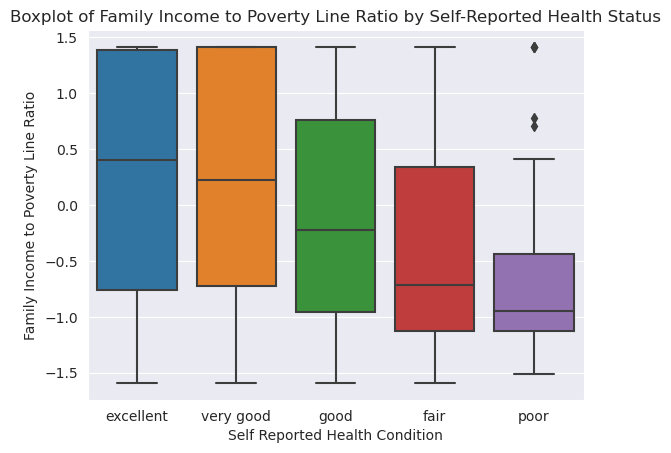

In [21]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

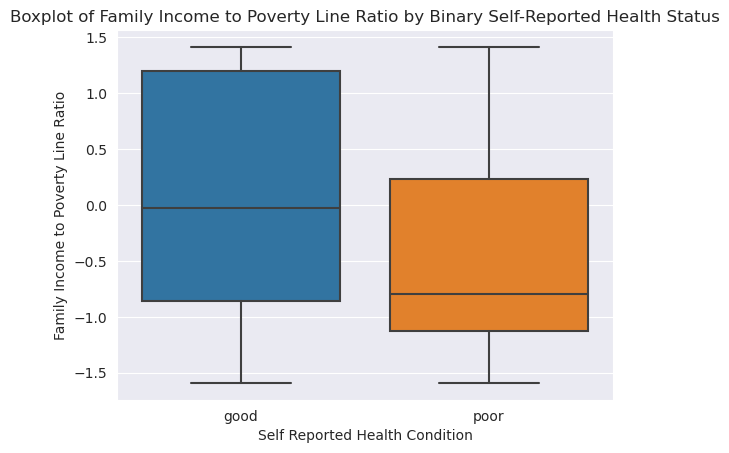

In [22]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

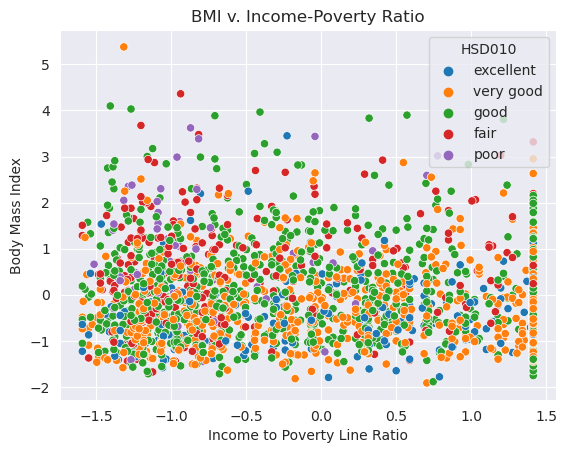

In [23]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

## Principal Component Analysis

In [24]:
nhanes_scaled_dropped = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

I choose an initial 30 components. This dataset isn't a massive one, so 30 seems reasonable for an initial check - if I find that there are still useful features past 30, I might adjust and pick more.

### Barplot of Components

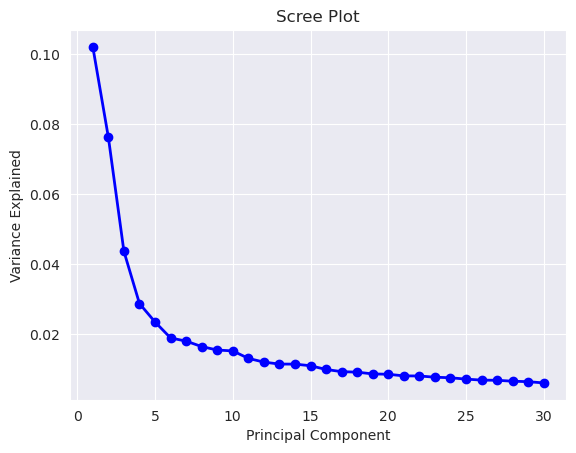

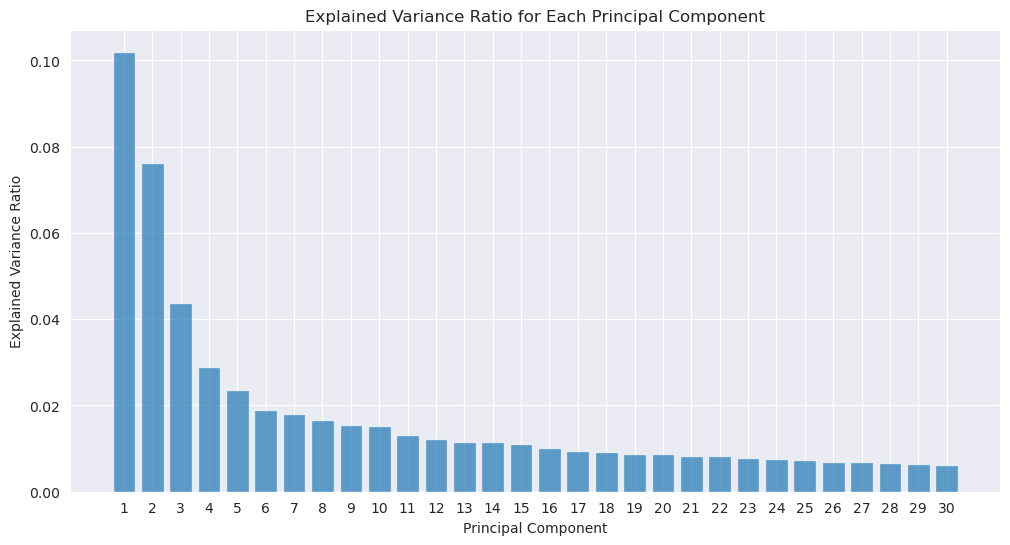

In [25]:

# load library 
# ----------
from sklearn.decomposition import PCA

# apply PCA
# ----------
pca = PCA(n_components=30)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_dropped)

# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Get the explained variance ratios
explained_var_ratio = pca.explained_variance_ratio_

# Plot the barplot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio, alpha=0.7, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xticks(range(1, len(explained_var_ratio) + 1))
plt.show()

### How many components will you use to fit a supervised learning model?

There seem to be three most important components, then everything in the 5-10 range also seems marginally useful. I guess you could argue for including components 11-15 as well, but I am choosing to proceed with 10.

### 2D Scatterplot of the first two components

In [26]:
pca_df = pd.DataFrame(data = principalComponents_nhanes, index=nhanes_scaled_dropped.index)  

pca_sp = PCA(n_components=2)
principalComponents_nhanes_sp = pca_sp.fit_transform(pca_df)


# convert into a dataframe
# ----------
pca_df_sp = pd.DataFrame(data = principalComponents_nhanes_sp, 
                      columns = ['principal component 1', 
                                 'principal component 2'])

pca_df_sp.head()

,principal component 1,principal component 2
0,9.527810,-0.816251
1,-5.838320,-3.692671
2,-0.719457,-2.573167
3,3.533633,-2.577005
4,-6.872118,-4.194206


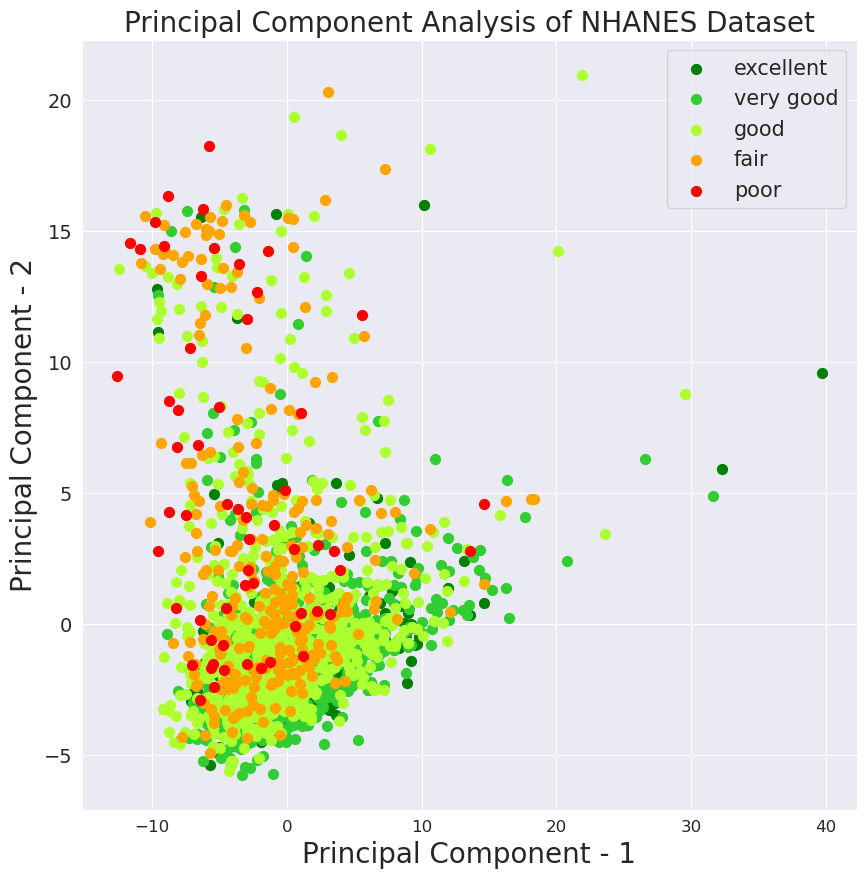

In [27]:
# Plot
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.ylabel('Principal Component - 2', fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset", fontsize=20)

# Define targets and colors
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['green', 'limegreen', 'greenyellow', 'orange', 'red']

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = (nhanes_scaled['HSD010'] == target).reset_index(drop=True)
    plt.scatter(pca_df_sp.loc[indicesToKeep, 'principal component 1'],
                pca_df_sp.loc[indicesToKeep, 'principal component 2'], c=color, s=50)

# Show figure
plt.legend(targets, prop={'size': 15})
plt.show()

I notice two features. First - there is a lot of clustering of variation shared by both variables towards the bottom left quadrant, with a bit (but not much) of variation that seems unique to each variable as they increase. There's not a lot of distinct patterns based on HSD010 response to note here.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I choose the elbow method for k-means clustering. Over a range of potential clusters, the method tests, at different k's, how much variance is explained by clustering. By plotting these clusters, we can then see at what points variance is effectively being explained by each k and can make a decision about which one to include.

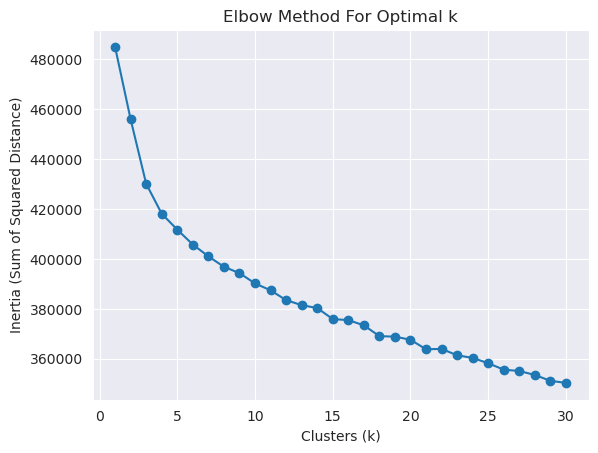

In [28]:
#we initiate an intertia object
inertia = []
#range of K's - arbitrarily I pick 1-30
k_range = range(1, 31)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled_dropped)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distance)')
plt.show()

Seems like its pretty reasonable to choose anywhere from like 3-5 clusters, because the marginal value of each cluster after that seems to drop off. Arbitrarily I'll pick 5.

### Cluster nhanes

In [29]:
np.random.seed(10)
# Initialize the KMeans model
kmeans = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled_dropped)



In [30]:
# Fit the model to your data (excluding any outcome variable)

# Add the cluster labels to your DataFrame
nhanes_scaled_dropped['Cluster'] = kmeans.labels_

# Print the cluster centers
cluster_centers_df = pd.DataFrame(data=kmeans.cluster_centers_, columns=nhanes_scaled_dropped.columns[:-1])

# Print the cluster centers
print("Cluster Centers:")
print(cluster_centers_df)

# Print the cluster labels for each data point
print("Cluster Labels:")
print(nhanes_scaled_dropped['Cluster'].value_counts())



Cluster Centers:
   DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
0       0.0 -0.044728    0.0 -0.104559 -0.084496 -0.109332  0.160159   
1       0.0 -0.094412    0.0  0.143323 -0.003795 -0.205411  0.166909   
2       0.0  0.045676    0.0  0.064890 -0.039577  0.023221 -0.071619   
3       0.0  0.007262    0.0  0.026137  0.177433 -0.008052 -0.006924   
4       0.0 -0.004263    0.0 -0.080526 -0.004963  0.159344 -0.100116   

   DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845   PAAQUEX  \
0 -0.019375  0.055591 -0.077691  ...  0.264849 -0.545119  0.554773 -0.472287   
1  0.097307 -0.028501 -0.044974  ...  1.154792 -0.552849  0.662673 -0.484200   
2 -0.057306  0.091772 -0.063032  ... -0.226788  0.235816 -0.216029 -0.376019   
3  0.016711  0.015285 -0.030644  ... -0.113314  0.137343 -0.155138 -0.043469   
4  0.069300 -0.223691  0.238420  ... -0.207517  0.242867 -0.312108  1.382031   

     SMQ860  SMQ870    SMQ872    SMQ874    SMQ878  SMAQUEX.x  
0  0.2

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

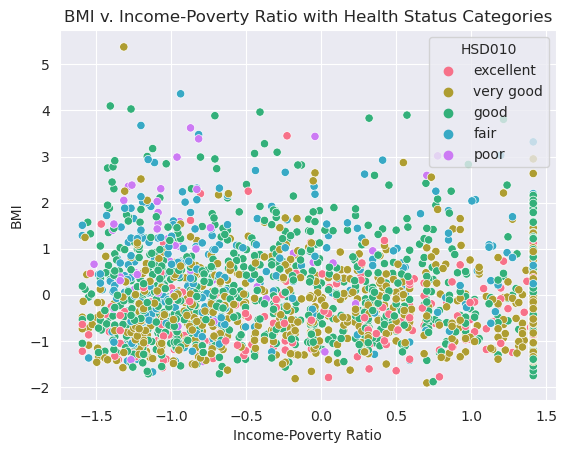

In [31]:
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="husl", data=nhanes_scaled) #need to use scaled data because it has the health status var

#labels
ax.set(xlabel="Income-Poverty Ratio", ylabel="BMI")
ax.set_title("BMI v. Income-Poverty Ratio with Health Status Categories")

#show
plt.show()

This looks like a pretty big mess to be honest. There isn't much interpretability that I believe we get with this sort of graph.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

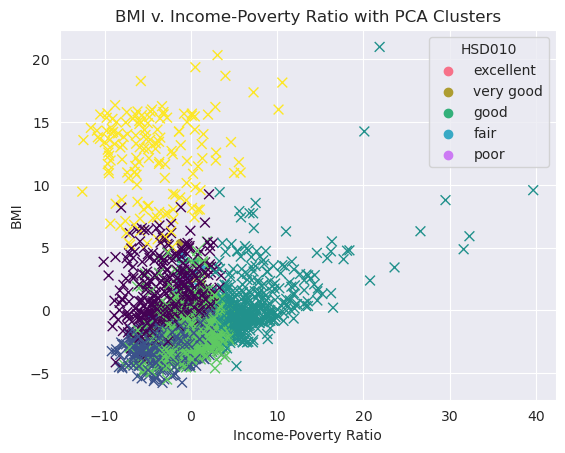

In [32]:
#train kmeans
kmeans_pca = KMeans(n_clusters=5,
                n_init=10,
                max_iter=300 #default
                ).fit(principalComponents_nhanes)
#plot
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="husl", data=nhanes_scaled)

ax.scatter(principalComponents_nhanes[:, 0], principalComponents_nhanes[:, 1], c=kmeans_pca.labels_, cmap='viridis', marker='x', s=50, linewidths=1)

#labels
ax.set(xlabel="Income-Poverty Ratio", ylabel="BMI")
ax.set_title("BMI v. Income-Poverty Ratio with PCA Clusters")

#show
plt.show()

With clusters, we start to see observations form more of an interpretable pattern vs the prior graph.

(Kasey, is there a recommended way to get the palettes to synchronize? I spent a bit too much time trying to figure this out).

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [33]:
# partition data
# -----------
y = nhanes_scaled['HSD010_binary']

#need to remap into a binary variable with 1s and 0s
label_mapping = {'good': 1, 'poor': 0}
y = y.map(label_mapping)
y = np.array(y)[:, np.newaxis]

X = nhanes_scaled_dropped


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [35]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(units=2, 
                input_dim=X_train.shape[1], 
                kernel_initializer='normal', 
                activation='relu'))

model.add(Dense(units=1,  # Output layer for binary classification
                kernel_initializer='normal', 
                activation='sigmoid'))  # Sigmoid activation for binary classification

# Add any additional layers you wish here
model.compile(loss='binary_crossentropy', #because binary variable
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2)               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 0.6954 - accuracy: 0.4444 - val_loss: 0.6929 - val_accuracy: 0.6512 - 602ms/epoch - 75ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6906 - accuracy: 0.7371 - val_loss: 0.6890 - val_accuracy: 0.7810 - 35ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6871 - accuracy: 0.8307 - val_loss: 0.6856 - val_accuracy: 0.8275 - 35ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6841 - accuracy: 0.8508 - val_loss: 0.6825 - val_accuracy: 0.8469 - 35ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6811 - accuracy: 0.8424 - val_loss: 0.6793 - val_accuracy: 0.8469 - 35ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6779 - accuracy: 0.8404 - val_loss: 0.6758 - val_accuracy: 0.8469 - 34ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6738 - accuracy: 0.8437 - val_loss: 0.6711 - val_accuracy: 0.8411 - 36ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6680 - accuracy: 0.8482 - val_loss: 0.6643 - val_accuracy: 0.8469 - 36ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6595 - a

### Neural Network on Principal Components

In [38]:
# partition data
# -----------
#y same as before
X = pca_df #change to the pca df I had
X = pca_df.iloc[:, :10]  # Selecting the first 10 columns

#rerun split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [39]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(2, 
                input_dim= X_train.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu'))
model.add(Dense(units=1,  # Output layer for binary classification
                kernel_initializer='normal', 
                activation='sigmoid'))  # Sigmoid activation for binary classification

# Add any additional layers you wish here
model.compile(loss='binary_crossentropy', #because binary variable
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 0.7015 - accuracy: 0.4244 - val_loss: 0.6983 - val_accuracy: 0.5426 - 606ms/epoch - 76ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6964 - accuracy: 0.5504 - val_loss: 0.6935 - val_accuracy: 0.6395 - 32ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6918 - accuracy: 0.6570 - val_loss: 0.6890 - val_accuracy: 0.7248 - 32ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6875 - accuracy: 0.7526 - val_loss: 0.6849 - val_accuracy: 0.8023 - 32ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6837 - accuracy: 0.8140 - val_loss: 0.6811 - val_accuracy: 0.8450 - 32ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6800 - accuracy: 0.8314 - val_loss: 0.6775 - val_accuracy: 0.8488 - 33ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6766 - accuracy: 0.8359 - val_loss: 0.6740 - val_accuracy: 0.8488 - 32ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6733 - accuracy: 0.8359 - val_loss: 0.6707 - val_accuracy: 0.8488 - 32ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6701 - a

### Neural Network on Principal Components + Cluster Membership

In [40]:
# partition data
# -----------
#y same as before
#we iterate off the prior X to get the combined pca (the prior x) and the cluster 
X_pcacluster = np.column_stack((X, nhanes_scaled_dropped['Cluster']))

X_train, X_test, y_train, y_test = train_test_split(X_pcacluster, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [41]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(2, 
                input_dim= X_train.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu'))
model.add(Dense(units=1,  # Output layer for binary classification
                kernel_initializer='normal', 
                activation='sigmoid'))  # Sigmoid activation for binary classification

# Add any additional layers you wish here
model.compile(loss='binary_crossentropy', #because binary variable
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 1s - loss: 0.6885 - accuracy: 0.8198 - val_loss: 0.6858 - val_accuracy: 0.8488 - 625ms/epoch - 78ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6838 - accuracy: 0.8359 - val_loss: 0.6808 - val_accuracy: 0.8488 - 34ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6787 - accuracy: 0.8359 - val_loss: 0.6753 - val_accuracy: 0.8488 - 34ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6727 - accuracy: 0.8359 - val_loss: 0.6690 - val_accuracy: 0.8488 - 32ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6659 - accuracy: 0.8359 - val_loss: 0.6620 - val_accuracy: 0.8488 - 31ms/epoch - 4ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6585 - accuracy: 0.8359 - val_loss: 0.6541 - val_accuracy: 0.8488 - 31ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6499 - accuracy: 0.8359 - val_loss: 0.6455 - val_accuracy: 0.8488 - 32ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6406 - accuracy: 0.8359 - val_loss: 0.6360 - val_accuracy: 0.8488 - 32ms/epoch - 4ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6305 - a

Our latter two models seem to have the same validated accuracy of .8488, which is better than the raw features. I like the concept of using PCA with clustering and can imagine that with a much bigger dataset and surely a multitude of other features that this would be pretty useful, even if maybe with this data, it's unnecessary.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA aims to identify features already in the dataset that are the most impactful, helping the research in identifying only the "most important" features to be used in their analyses. In contrast, clustering uses the features that are present in the data to identify when units (based on these features) may represent a similar pattern within cluster but a distinct pattern compared to other clusters. Compared to PCA which reduces dimensions, clustering adds a new one (the cluster assignment) and is built off the features that it is fed.  

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I noticed some marginal improvement using PCA and clustering, which is likely due to the added clusters that the raw features did not include. Survey data tends to have limited features (because of the nature of surveying - there are only so many questions you can ask). I imagine with a larger dataset, or if we managed to merge NHANES responses with a bunch of other datasets, we would have many more features that we would need to parse through. However, given the smaller (in terms of n and covariates) dataset we use here compared to some of the other big datasets we normally apply these methods to, it makes sense that there is a bit smaller benefit to doing these more advanced methods.  

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques are able to identify patterns (such as a cluster) in the dataset that may not be intuitive for the researcher to find but may be useful in explaining variance in a way that improves our predictive abilities when using supervised learning tasks. Alternatively, unsupervised methods may be good at paring down some of the things that a researcher thinks might be interesting to include (such as a quadratic formulation of every single linear variable) rather than include all these in the model.